
# Cassava Leaf Disease Detection


## Using Image Recognition to identify Diseased Plants

### Lynn Anderson


# Overview

The objective of this project was to build a model basd on a neural network that can accurately identify diseased cassava plants. Cassava roots are an important source of calories and nutrition for many people, especially in
sub-Saharan Africa. As the human population increases, it is increasingly important to prioritize
crop health, as fertile land is finite and precious. Identifying diseased plants and appropriately
treating them in a timely manner is important to ensure adequate yields. In this project, I will
train and develop a model that, when given images of Cassava leaves, can accurately
classify that plant as healthy or belonging to a diseased plant. A basic neural network will be the baseline model, with accuracy of the test data used to determine model performance. I investigated models with different numbers of hidden
layers, different regularization techniques, and early stopping. I also looked at pre-trained
networks to see if models based on those are higher performing.

# Business Understanding

An agricultural company specializing in treating plant diseases is seeking to improve their effiency and accuracy in identifying diseased plants cassava plants. It is important they can accurately identify plants in need of treatment and determine the best solutions for their customers. 


# Data 

The data for this project was sourced  from the Tensorflow Cassava dataset -
https://www.tensorflow.org/datasets/catalog/cassava
The data consists of leaf images for the cassava plant depicting healthy and four disease
conditions- Cassava Mosaic Disease (CMD), Cassava Bacterial Blight (CBB), Cassava Greem
Mite (CGM), and Cassava Brown Streak Disease (CBSD). There were a total of 5,656 labelled images used in this project, which were split into a training and test set.

The number of images per class are unbalanced, with the two disease classes CMD and CBSD
having 72% of the images. Dealing with this will require some experimenting and manipulation. for example, I might need to generate additional training data, or train the algorithm to only
identify “diseased” vs normal plants.
The primary modeling techniques to be investigated will be those based on neural networks,
particularly, I anticipate, Multi Layer Perceptrons (MLPs) and Convolutional Neural Networks
(CNNs). The target variable is categorical, with 5 possible categories- normal or belonging to
one of the 4 diseases.  




# Data Preparation

In [3]:
# run if needed 
#pip install tensorflow-datasets
#pip install tensorflow
#pip install scikeras
#pip install keras
#pip install lime

In [4]:
#pip install jupyter-resource-usage caused problems!!!!!!!!!!

In [5]:
# imports
import pandas as pd
import os
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from keras import layers
from keras import models
from keras import regularizers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from scikeras.wrappers import KerasClassifier, KerasRegressor
import tensorflow.keras as keras
import PIL.Image as Image
import lime

#import tensorflow_addons as tfa
#import tensorflow_datasets as tdfs

### Function to visualize model performance

This function plots the loss and accuracy of both training and validation data across the epochs.

In [6]:
def visualize_training_results(results):
    history = results.history
    plt.figure(figsize=(6, 4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure(figsize=(6, 4))
    plt.plot(history['val_acc'])
    plt.plot(history['acc'])
    plt.legend(['val_acc', 'acc'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


### preview files

In [7]:
os.listdir('./data')

['cassava-disease.zip',
 'extraimages.zip',
 'random.txt',
 'sample_submission_file.csv',
 'test',
 'test.zip',
 'train',
 'train.zip']

## *** run to unzip files***

run the following cells to unzip the files

#### unzip the Cassava Disease file

In [8]:
from zipfile import ZipFile
  
# loading the temp.zip and creating a zip object
with ZipFile("data/cassava-disease.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path='./data')

#### unzip test folder

In [9]:
with ZipFile("data/test.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path='./data')

#### unzip train folder

In [10]:
with ZipFile("data/train.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall(
        path='./data')

#### preview files

In [11]:
print(os.listdir("./data"))

['cassava-disease.zip', 'extraimages.zip', 'random.txt', 'sample_submission_file.csv', 'test', 'test.zip', 'train', 'train.zip']


## ***Resume here if files are unzipped**

### preview image file names

In [12]:
import os
Id = []
for dirname, _, filenames in os.walk('./data/train'):
    for filename in filenames:
        Id.append(os.path.join(dirname, filename))
Id[:5]

['./data/train\\cbb\\train-cbb-0.jpg',
 './data/train\\cbb\\train-cbb-1.jpg',
 './data/train\\cbb\\train-cbb-10.jpg',
 './data/train\\cbb\\train-cbb-100.jpg',
 './data/train\\cbb\\train-cbb-101.jpg']

### Make into dataframe

In [13]:
train=pd.DataFrame()
train=train.assign(filename=Id)
train.head()

,filename
0,./data/train\cbb\train-cbb-0.jpg
1,./data/train\cbb\train-cbb-1.jpg
2,./data/train\cbb\train-cbb-10.jpg
3,./data/train\cbb\train-cbb-100.jpg
4,./data/train\cbb\train-cbb-101.jpg


### preview train folder

In [14]:
print(os.listdir("./data/train"))
print(np.shape(os.listdir("./data/train")))

['cbb', 'cbsd', 'cgm', 'cmd', 'healthy']
(5,)


There are 5 files in the train folder, one for each class.

In [15]:
for sub in os.listdir("./data/train"):
    print(os.listdir("./data/train/" + sub)[:5])
    print(np.shape(os.listdir("./data/train/" + sub)))

['train-cbb-0.jpg', 'train-cbb-1.jpg', 'train-cbb-10.jpg', 'train-cbb-100.jpg', 'train-cbb-101.jpg']
(466,)
['train-cbsd-0.jpg', 'train-cbsd-1.jpg', 'train-cbsd-10.jpg', 'train-cbsd-100.jpg', 'train-cbsd-1000.jpg']
(1443,)
['train-cgm-0.jpg', 'train-cgm-1.jpg', 'train-cgm-10.jpg', 'train-cgm-100.jpg', 'train-cgm-101.jpg']
(773,)
['train-cmd-0.jpg', 'train-cmd-1.jpg', 'train-cmd-10.jpg', 'train-cmd-100.jpg', 'train-cmd-1000.jpg']
(2658,)
['train-healthy-0.jpg', 'train-healthy-1.jpg', 'train-healthy-10.jpg', 'train-healthy-100.jpg', 'train-healthy-101.jpg']
(316,)


In [16]:
print(os.listdir("./data/test"))
print(np.shape(os.listdir("./data/test")))

['0']
(1,)


The data in the test directory is not labelled and was used for a competion. I will not be using it in this project.

### Preprocess images

In [38]:
train_data_dir = 'data/train'

# Get all the data in the directory data/train (790 images), and reshape them
train_generator = ImageDataGenerator().flow_from_directory(
        train_data_dir, 
        target_size=(64, 64), batch_size=5656)

# Create the datasets
train_images, y_train = next(train_generator)


Found 5656 images belonging to 5 classes.


#### preview image labels

In [18]:
y_train

array([[1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

The labels are already in a format suited for modeling.

In [19]:
y_train[17]

array([0., 0., 0., 1., 0.], dtype=float32)

In [20]:
# preview shape
print(np.shape(train_images))
print(np.shape(y_train))

(5656, 128, 128, 3)
(5656, 5)


### reshape images

The images must be reshaped into a tensor before being input into a neural network model.

In [39]:
train_img_unrow = train_images.reshape(5656, -1)#.astype(uint8)

# Preview the shape of train_img_unrow
print(np.shape(train_img_unrow))

(5656, 12288)


#### normalize pixel values

In [40]:
train_img_unrow /= 255.

# Binary labeling

Label the data as belonging to one of 2 classes, healthy or diseased.

In [24]:
# make dataframe and preview
df = pd.DataFrame(y_train)
df

,0,1,2,3,4
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
5651,0.0,0.0,0.0,1.0,0.0
5652,0.0,1.0,0.0,0.0,0.0
5653,0.0,0.0,0.0,1.0,0.0
5654,0.0,0.0,1.0,0.0,0.0


In [25]:
# copy the dataframe
new=df.copy()

new


,0,1,2,3,4
0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...
5651,0.0,0.0,0.0,1.0,0.0
5652,0.0,1.0,0.0,0.0,0.0
5653,0.0,0.0,0.0,1.0,0.0
5654,0.0,0.0,1.0,0.0,0.0


In [26]:
new.loc[new[4]==1,"Healthy"]=1
new.loc[new[4]==0,"Healthy"]=0
new.loc[new[4]==1,"Diseased"]=0
new.loc[new[4]==0,"Diseased"]=1
new

,0,1,2,3,4,Healthy,Diseased
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,1.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,1.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
5651,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5652,0.0,1.0,0.0,0.0,0.0,0.0,1.0
5653,0.0,0.0,0.0,1.0,0.0,0.0,1.0
5654,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [27]:
new.drop([0, 1, 2, 3, 4], axis=1, inplace=True)

In [28]:
new.tail(5)

,Healthy,Diseased
5651,0.0,1.0
5652,0.0,1.0
5653,0.0,1.0
5654,0.0,1.0
5655,0.0,1.0


In [29]:
# check for any null entries
new.isnull().sum()

Healthy     0
Diseased    0
dtype: int64

In [30]:
new['Healthy'].sum()


316.0

In [31]:
new['Diseased'].sum()


5340.0

In [32]:
316 / 5340

0.05917602996254682

<AxesSubplot:>

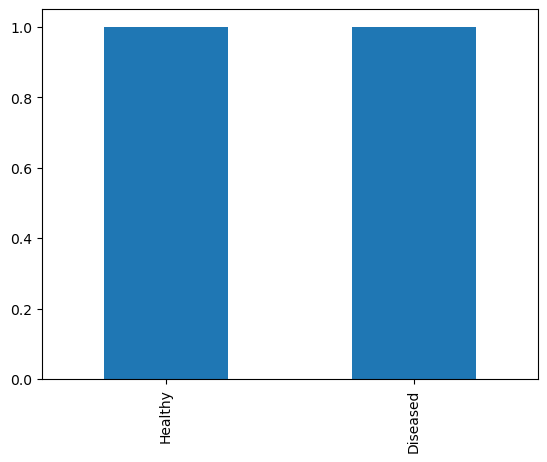

In [33]:
#new['Healthy'].plot(kind='bar')
new.columns.value_counts().plot(kind='bar')

# Modeling

### *** Run all above*** for data preparation. The following cells may take a while to run.

## img class w MLPs

## train-test split

In [46]:
final_train, final_test, train_labels, test_labels= train_test_split(train_img_unrow, y_train, test_size=0.2, random_state=42,shuffle=True)


### Basic neural network model

In [47]:
#instantiate and train model  -12288 input shape if 64 pix
np.random.seed(42)
model_1 = models.Sequential()
model_1.add(layers.Dense(256, activation='tanh', input_shape=(12288,)))
model_1.add(layers.Dense(5, activation='softmax'))

model_1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['acc'])
model_1.summary()
results_1 = model_1.fit(final_train, 
                        train_labels,
                        epochs=10,
                        batch_size=12,
                        validation_data=(final_test, test_labels))


Epoch 1/10


377/377 [==============================] - 22s 54ms/step - loss: 1.4812 - acc: 0.4337 - val_loss: 1.3912 - val_acc: 0.4488
Epoch 2/10
377/377 [==============================] - 20s 52ms/step - loss: 1.3848 - acc: 0.4359 - val_loss: 1.3453 - val_acc: 0.4532
Epoch 3/10
377/377 [==============================] - 19s 51ms/step - loss: 1.3570 - acc: 0.4534 - val_loss: 1.5711 - val_acc: 0.4496
Epoch 4/10
377/377 [==============================] - 20s 52ms/step - loss: 1.3583 - acc: 0.4560 - val_loss: 1.5960 - val_acc: 0.2721
Epoch 5/10
377/377 [==============================] - 20s 54ms/step - loss: 1.3361 - acc: 0.4622 - val_loss: 1.3182 - val_acc: 0.4576
Epoch 6/10
377/377 [==============================] - 20s 53ms/step - loss: 1.3229 - acc: 0.4620 - val_loss: 1.3742 - val_acc: 0.3542
Epoch 7/10
377/377 [==============================] - 20s 53ms/step - loss: 1.2899 - acc: 0.4867 - val_loss: 1.3552 - val_acc: 0.4443
Epoch 8/10
377/377 [==============================] - 20s 52

With a training accuracy of 48.5% and testing accuracy of 47%, there is lots of room for improvement. 

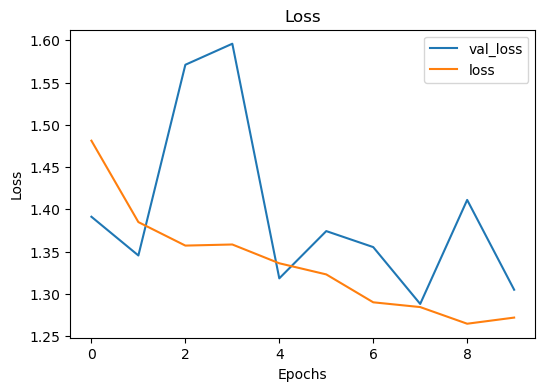

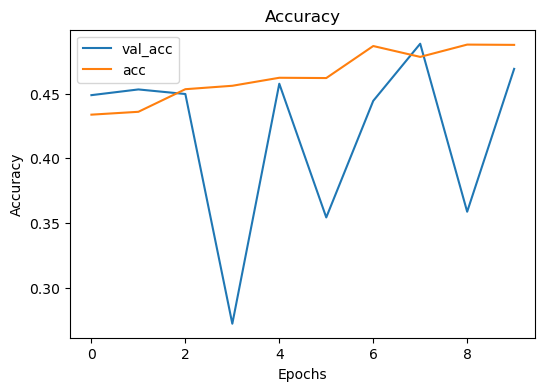

In [49]:
visualize_training_results(results_1)

comments.....

### Neural network with 1 hidden layer

Next I looked at a model with one additional hidden layer. It performed better on the training data but the testing accuracy was about the same.

In [50]:
np.random.seed(42)
model_2 = models.Sequential()
model_2.add(layers.Dense(256, activation='relu', input_shape=(49152,))) 
model_2.add(layers.Dense(32, activation='relu'))
model_2.add(layers.Dense(5, activation='sigmoid'))
model_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

results_2 = model_2.fit(final_train,
                    train_labels,
                    epochs=10,
                    batch_size=12,
                    validation_data=(final_test, test_labels))

Epoch 1/10
377/377 [==============================] - 22s 55ms/step - loss: 0.4366 - acc: 0.4662 - val_loss: 0.4337 - val_acc: 0.4488
Epoch 2/10
377/377 [==============================] - 20s 53ms/step - loss: 0.4251 - acc: 0.4814 - val_loss: 0.4361 - val_acc: 0.4488
Epoch 3/10
377/377 [==============================] - 20s 54ms/step - loss: 0.4188 - acc: 0.4874 - val_loss: 0.4460 - val_acc: 0.4496
Epoch 4/10
377/377 [==============================] - 20s 54ms/step - loss: 0.4126 - acc: 0.4960 - val_loss: 0.4358 - val_acc: 0.4594
Epoch 5/10
377/377 [==============================] - 20s 54ms/step - loss: 0.4071 - acc: 0.5053 - val_loss: 0.4320 - val_acc: 0.4505
Epoch 6/10
377/377 [==============================] - 20s 54ms/step - loss: 0.4022 - acc: 0.5157 - val_loss: 0.4218 - val_acc: 0.4814
Epoch 7/10
377/377 [==============================] - 21s 55ms/step - loss: 0.3964 - acc: 0.5243 - val_loss: 0.4253 - val_acc: 0.4876
Epoch 8/10
377/377 [==============================] - 21s 55ms

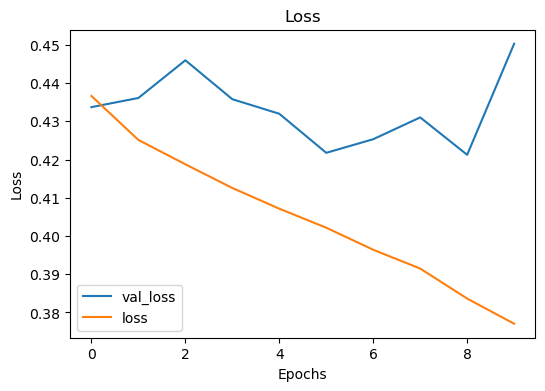

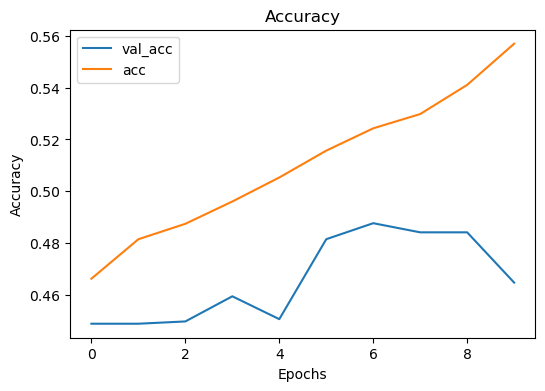

In [51]:
visualize_training_results(results_2)

comments - after 10 eopochs.....

### Neural nettwork model with 2 hidden layers

I wanted to see how adding another hidden layer would affect performance. 

In [52]:
np.random.seed(42)
model_3 = models.Sequential()
model_3.add(layers.Dense(256, activation='relu', input_shape=(49152,))) 
model_3.add(layers.Dense(64, activation='relu'))
model_3.add(layers.Dense(16, activation='relu'))
model_3.add(layers.Dense(5, activation='sigmoid'))
model_3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

results_3 = model_3.fit(final_train,
                    train_labels,
                    epochs=10,
                    batch_size=12,
                    validation_data=(final_test, test_labels))

Epoch 1/10
377/377 [==============================] - 21s 52ms/step - loss: 0.4416 - acc: 0.4567 - val_loss: 0.4364 - val_acc: 0.4488
Epoch 2/10
377/377 [==============================] - 20s 53ms/step - loss: 0.4269 - acc: 0.4768 - val_loss: 0.4374 - val_acc: 0.4302
Epoch 3/10
377/377 [==============================] - 20s 53ms/step - loss: 0.4175 - acc: 0.4823 - val_loss: 0.4342 - val_acc: 0.4735
Epoch 4/10
377/377 [==============================] - 22s 59ms/step - loss: 0.4111 - acc: 0.4993 - val_loss: 0.4270 - val_acc: 0.4814
Epoch 5/10
377/377 [==============================] - 23s 61ms/step - loss: 0.4053 - acc: 0.5042 - val_loss: 0.4257 - val_acc: 0.4876
Epoch 6/10
377/377 [==============================] - 22s 57ms/step - loss: 0.3982 - acc: 0.5296 - val_loss: 0.4275 - val_acc: 0.4761
Epoch 7/10
377/377 [==============================] - 21s 55ms/step - loss: 0.3921 - acc: 0.5283 - val_loss: 0.4176 - val_acc: 0.4903
Epoch 8/10
377/377 [==============================] - 21s 55ms

The training accuracy was similar to the previous model, but there was a small increase in validation accuracy.

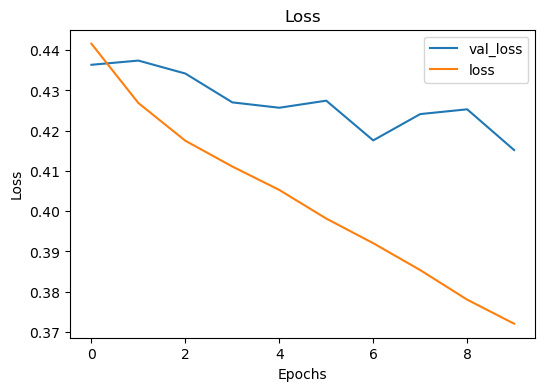

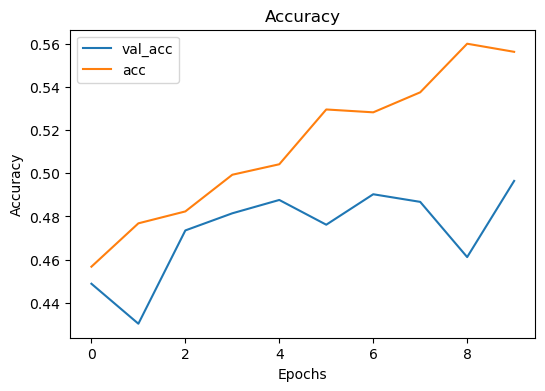

In [53]:
visualize_training_results(results_3)

comments 

### Grid search to find optimal parameters

I wanted to experiment with different optimizers, batch sizes, and epochs to find the optimal parameters for the neural nework model.


In [5]:
def buildModel(optimizer):
    # Initialising the ANN
    classifier = models.Sequential()
    
    # Adding the input layer and the first hidden layer
    classifier.add(layers.Dense(128, activation = 'relu', input_shape=(49152,))) 
    
    # Adding the second hidden layer
    classifier.add(layers.Dense(32, activation='relu'))
        
    # Adding the output layer
    classifier.add(layers.Dense(5, activation='sigmoid'))
    
    # Compiling the ANN
    classifier.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
    
    return classifier



In [61]:
classifier = KerasRegressor(build_fn = buildModel('adam'))
#What hyperparameter we want to play with
parameters = {'batch_size': [16, 32, 64, 128],
              'epochs': [10, 50, 100],
              'optimizer': ['adam', 'sgd' 'rmsprop']}
grid_search = GridSearchCV(estimator = classifier,
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 5)
grid_search = grid_search.fit(final_train, train_labels, verbose = 0)

INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpar8exkz2\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpar8exkz2\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmph0iaid03\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmph0iaid03\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpafi3uzy1\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpafi3uzy1\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpa77s08ue\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpa77s08ue\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp2e_sp63b\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp2e_sp63b\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpeogc9rzz\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpeogc9rzz\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppm90eqbj\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppm90eqbj\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3etsi0sk\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3etsi0sk\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpu7s6toky\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpu7s6toky\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp9cukaxhm\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp9cukaxhm\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmptpf4qi8u\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmptpf4qi8u\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp6lzt7rvz\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp6lzt7rvz\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 0s 6ms/step


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpurkxyfb_\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpurkxyfb_\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp1j9w2d2v\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp1j9w2d2v\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpd_5yauyl\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpd_5yauyl\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzrqhhoha\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzrqhhoha\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp9y49ar7_\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp9y49ar7_\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmptbvdjw4h\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmptbvdjw4h\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp4a_ufbsw\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp4a_ufbsw\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 0s 6ms/step


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp85d670gz\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp85d670gz\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpw7jlrotr\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpw7jlrotr\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpcj6egp6l\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpcj6egp6l\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpnbmq69be\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpnbmq69be\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmprsf9mpvw\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmprsf9mpvw\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 0s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpjx70vr1g\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpjx70vr1g\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpn6zc9gff\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpn6zc9gff\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpyu9g8c9w\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpyu9g8c9w\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 7ms/step


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp5znm_tq4\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp5znm_tq4\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpk2lg_46q\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpk2lg_46q\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpbsta4nrt\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpbsta4nrt\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 7ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp703kim2_\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp703kim2_\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 [==============================] - 1s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpuevq_ajr\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpuevq_ajr\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmphr0z4q1m\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmphr0z4q1m\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpkehrmfw9\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpkehrmfw9\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpvjpe374w\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpvjpe374w\assets


C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp_s5detow\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp_s5detow\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpu3or09gk\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpu3or09gk\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpynpusb69\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpynpusb69\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3g8nh940\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3g8nh940\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpdv8ieyuz\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpdv8ieyuz\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp4mxtq92x\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp4mxtq92x\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmphmrr5kke\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmphmrr5kke\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8olx4s4o\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8olx4s4o\assets


C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpaq6xnv0w\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpaq6xnv0w\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp77m_0c1b\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp77m_0c1b\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppmoia4uv\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppmoia4uv\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpbjiwz05a\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpbjiwz05a\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 1s 13ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmputpkf2t9\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmputpkf2t9\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpd29dy030\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpd29dy030\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpw0qv5y4h\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpw0qv5y4h\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 1s 15ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3kjk63mm\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3kjk63mm\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 6s 12ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp63hwss8p\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp63hwss8p\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmphs9lxd34\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmphs9lxd34\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 8ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmphe93zx4l\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmphe93zx4l\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 1s 14ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpwpddq49n\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpwpddq49n\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 1s 13ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpb_qqtt_f\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpb_qqtt_f\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 10ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp44ycgo5w\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp44ycgo5w\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzmyf4yqx\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzmyf4yqx\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 9ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpys0wsrcf\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpys0wsrcf\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 11ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp_zh_yq1x\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp_zh_yq1x\assets


C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp9bbbe1ab\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp9bbbe1ab\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpkubg_bg8\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpkubg_bg8\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp5hd_i18i\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp5hd_i18i\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpe0lbh69k\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpe0lbh69k\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpxq_89the\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpxq_89the\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 15ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpucmt5cc6\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpucmt5cc6\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp4ws4862e\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp4ws4862e\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpks8ngqdz\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpks8ngqdz\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmprtjm4_fw\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmprtjm4_fw\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmph8y8g62_\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmph8y8g62_\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp0jgf7r5c\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp0jgf7r5c\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpd0sj213b\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpd0sj213b\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 20ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp86cjvjdv\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp86cjvjdv\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmprg8w5s0b\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmprg8w5s0b\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpj1oy2wpu\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpj1oy2wpu\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 15ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp80mp2eo4\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp80mp2eo4\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 16ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp1l0p3v44\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp1l0p3v44\assets


C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 17ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpl61herwm\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpl61herwm\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 18ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp5k6o5nzt\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp5k6o5nzt\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3u1zc02e\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp3u1zc02e\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmphr2npgxa\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmphr2npgxa\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 15ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpg6kf60f7\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpg6kf60f7\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 12ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp25zgyo_l\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp25zgyo_l\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpq98yka5z\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpq98yka5z\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp11q2himt\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp11q2himt\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 15ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmph6c5pjgt\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmph6c5pjgt\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 16ms/step


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpn9ixu47c\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpn9ixu47c\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp190hxfzs\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp190hxfzs\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 14ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp0udp3zf7\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp0udp3zf7\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 15ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpl6q0r8cq\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpl6q0r8cq\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 15ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpycwu2f9v\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpycwu2f9v\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpxq_qmn01\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpxq_qmn01\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 20ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp_20490q7\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp_20490q7\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 16ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpb9nehrn_\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpb9nehrn_\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 20ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpi6jbkgfy\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpi6jbkgfy\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 23ms/step


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzjnf34b_\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzjnf34b_\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 20ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpquqwk7fa\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpquqwk7fa\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 24ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpomycgaau\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpomycgaau\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 24ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpoj297nzs\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpoj297nzs\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 22ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpl421dli0\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpl421dli0\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 20ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpbhhja8dd\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpbhhja8dd\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 20ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpud98ocev\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpud98ocev\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 21ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppi7i8ow7\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppi7i8ow7\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 22ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzzozc6xj\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpzzozc6xj\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 19ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8719ibad\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8719ibad\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 20ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpp865qe6g\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpp865qe6g\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 22ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp08kpvkm8\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp08kpvkm8\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 33ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpuhkxg5xx\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpuhkxg5xx\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 22ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppb_sbfyg\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmppb_sbfyg\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 35ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8almtdvs\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp8almtdvs\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 33ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp30tyf4ep\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp30tyf4ep\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 31ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpdcmcfcmn\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpdcmcfcmn\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 30ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpv_jw158y\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpv_jw158y\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 35ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpgt3hwmfe\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpgt3hwmfe\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 31ms/step


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpkj2uk8nl\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpkj2uk8nl\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 31ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpldouoqba\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpldouoqba\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 31ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp1onl19ii\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp1onl19ii\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 1s 34ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp6qt9tul0\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp6qt9tul0\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 32ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp88yin6ga\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp88yin6ga\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 13ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpo7uaqfqj\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmpo7uaqfqj\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 2s 67ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp7yvohfx6\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp7yvohfx6\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


8/8 [==============================] - 0s 24ms/step
INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmps_w1spdw\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmps_w1spdw\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp9v41gtuu\assets


INFO:tensorflow:Assets written to: C:\Users\lalyn\AppData\Local\Temp\tmp9v41gtuu\assets
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


In [63]:
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters: " + str(best_parameters))

Best Parameters: {'batch_size': 16, 'epochs': 100, 'optimizer': 'adam'}


The best parameters for data are a batch size of 16, 100 epochs, and the adam optimizer.

In [3]:
visualize_training_results(HistoryBest)

NameError: name 'HistoryBest' is not defined

In [6]:
bestClassifier = buildModel('adam')
HistoryBest = bestClassifier.fit(final_train, train_labels, batch_size = 16, epochs =100 , verbose = 0)
plt.plot(results_2.history['acc'], label='Initial Parameters')
plt.plot(HistoryBest.history['acc'], label='GridSearchCV Best Parameters')
plt.title('Loss Function Over Epochs')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

NameError: name 'models' is not defined

## Neural Network model with L2 regularization

In [65]:
# Import regularizers
from keras import regularizers

np.random.seed(42)

L2_model = models.Sequential()

# Add the input and first hidden layer
L2_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(49152,)))

# Add another hidden layer
L2_model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

# Add an output layer
L2_model.add(layers.Dense(5, activation='softmax'))

# Compile the model
L2_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
L2_model_results = L2_model.fit(final_train, 
                            train_labels, 
                            epochs=100, 
                            batch_size=16, 
                            validation_data=(final_test, test_labels))

Epoch 1/100
283/283 [==============================] - 38s 126ms/step - loss: 3.7554 - acc: 0.3764 - val_loss: 2.3493 - val_acc: 0.4549
Epoch 2/100
283/283 [==============================] - 33s 116ms/step - loss: 1.9074 - acc: 0.4377 - val_loss: 1.5818 - val_acc: 0.4806
Epoch 3/100
283/283 [==============================] - 27s 97ms/step - loss: 1.5632 - acc: 0.4872 - val_loss: 1.6916 - val_acc: 0.4541
Epoch 4/100
283/283 [==============================] - 27s 97ms/step - loss: 1.4688 - acc: 0.4781 - val_loss: 1.5185 - val_acc: 0.4505
Epoch 5/100
283/283 [==============================] - 28s 98ms/step - loss: 1.4244 - acc: 0.4901 - val_loss: 1.4709 - val_acc: 0.4488
Epoch 6/100
283/283 [==============================] - 27s 97ms/step - loss: 1.4149 - acc: 0.4752 - val_loss: 1.4179 - val_acc: 0.4505
Epoch 7/100
283/283 [==============================] - 28s 97ms/step - loss: 1.3901 - acc: 0.4746 - val_loss: 1.4013 - val_acc: 0.4514
Epoch 8/100
283/283 [==============================] 

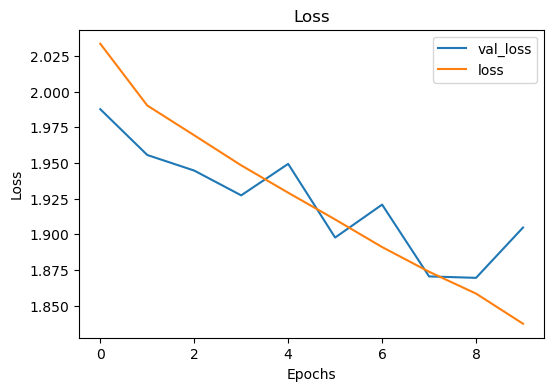

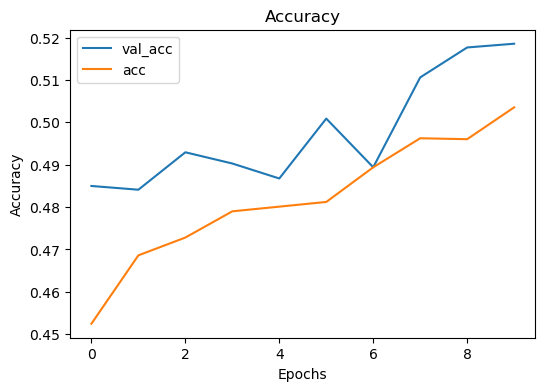

In [39]:
visualize_training_results(L2_model_results)

The model looks to perform more poorly than the basic models.

## Neural network model with L1 regularization

In [72]:
np.random.seed(42)

L1_model = models.Sequential()

# Add the input and first hidden layer
L1_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.005), input_shape=(49152,)))

# Add a hidden layer
L1_model.add(layers.Dense(32, kernel_regularizer=regularizers.l1(0.005), activation='relu'))

# Add an output layer
L1_model.add(layers.Dense(5, activation='softmax'))

# Compile the model
L1_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
L1_model_val = L1_model.fit(final_train, 
                            train_labels,
                            epochs=100, 
                            batch_size=16, 
                            validation_data=(final_test, test_labels))

Epoch 1/10
283/283 [==============================] - 14s 41ms/step - loss: 9.6220 - acc: 0.4149 - val_loss: 3.2647 - val_acc: 0.4664
Epoch 2/10
283/283 [==============================] - 11s 39ms/step - loss: 3.0617 - acc: 0.4587 - val_loss: 2.7732 - val_acc: 0.4664
Epoch 3/10
283/283 [==============================] - 10s 36ms/step - loss: 2.6548 - acc: 0.4708 - val_loss: 2.5025 - val_acc: 0.4664
Epoch 4/10
283/283 [==============================] - 12s 41ms/step - loss: 2.4371 - acc: 0.4699 - val_loss: 2.3575 - val_acc: 0.4664
Epoch 5/10
283/283 [==============================] - 11s 39ms/step - loss: 2.3173 - acc: 0.4708 - val_loss: 2.2772 - val_acc: 0.4664
Epoch 6/10
283/283 [==============================] - 11s 39ms/step - loss: 2.2459 - acc: 0.4708 - val_loss: 2.2176 - val_acc: 0.4664
Epoch 7/10
283/283 [==============================] - 12s 43ms/step - loss: 2.2154 - acc: 0.4708 - val_loss: 2.2103 - val_acc: 0.4664
Epoch 8/10
283/283 [==============================] - 12s 42ms

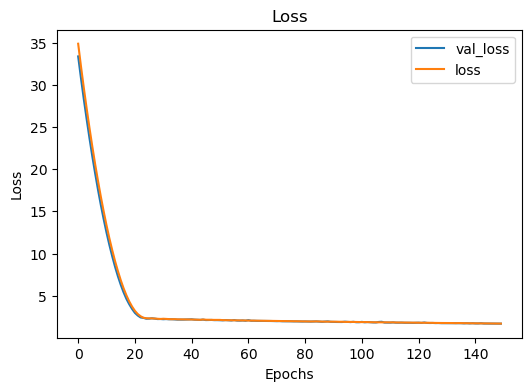

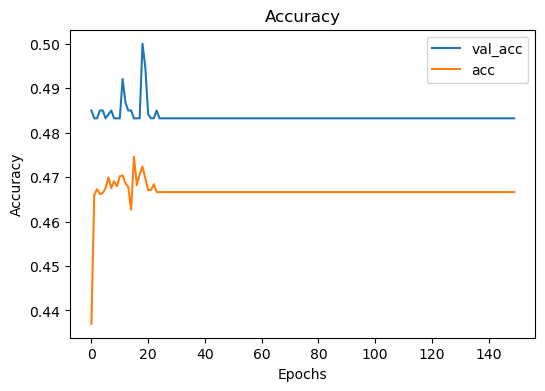

In [57]:
visualize_training_results(L1_model_val)

This model performs rather poorly as well, thus I will not be investigating models with regularization anymore.

## Neural network with dropout regularization

Dropout regularization is typically used when the model overfits the data. There is not reason to believe this is the case, but I owuld like to see how a model will perform.

In [73]:
np.random.seed(42)
dropout_model = models.Sequential()

# Implement dropout to the input layer
# NOTE: This is where you define the number of units in the input layer
dropout_model.add(layers.Dropout(0.3, input_shape=(49152,)))

# Add the first hidden layer
dropout_model.add(layers.Dense(128, activation='relu'))

# Implement dropout to the first hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the second hidden layer
dropout_model.add(layers.Dense(32, activation='relu'))

# Implement dropout to the second hidden layer 
dropout_model.add(layers.Dropout(0.3))

# Add the output layer
dropout_model.add(layers.Dense(5, activation='softmax'))


# Compile the model
dropout_model.compile(optimizer='adam', 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])

# Train the model
dropout_model_val = dropout_model.fit(final_train, 
                                      train_labels,
                                      epochs=100, 
                                      batch_size=16, 
                                      validation_data=(final_test, test_labels))

Epoch 1/10
283/283 [==============================] - 13s 37ms/step - loss: 1.6156 - acc: 0.4005 - val_loss: 1.3800 - val_acc: 0.4664
Epoch 2/10
283/283 [==============================] - 10s 34ms/step - loss: 1.4029 - acc: 0.4565 - val_loss: 1.3805 - val_acc: 0.4664
Epoch 3/10
283/283 [==============================] - 10s 34ms/step - loss: 1.3571 - acc: 0.4708 - val_loss: 1.3494 - val_acc: 0.4664
Epoch 4/10
283/283 [==============================] - 10s 34ms/step - loss: 1.3524 - acc: 0.4708 - val_loss: 1.3481 - val_acc: 0.4664
Epoch 5/10
283/283 [==============================] - 9s 33ms/step - loss: 1.3472 - acc: 0.4708 - val_loss: 1.3477 - val_acc: 0.4664
Epoch 6/10
283/283 [==============================] - 10s 34ms/step - loss: 1.3464 - acc: 0.4708 - val_loss: 1.3479 - val_acc: 0.4664
Epoch 7/10
283/283 [==============================] - 10s 34ms/step - loss: 1.3490 - acc: 0.4708 - val_loss: 1.3479 - val_acc: 0.4664
Epoch 8/10
283/283 [==============================] - 10s 37ms/

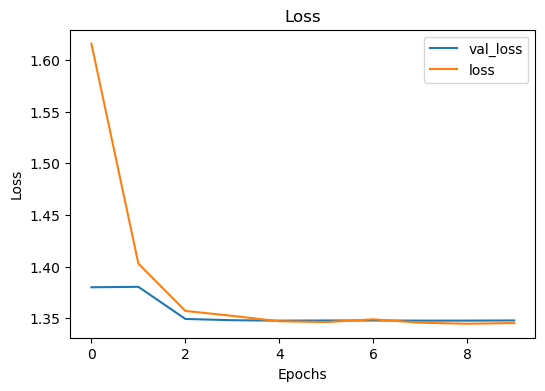

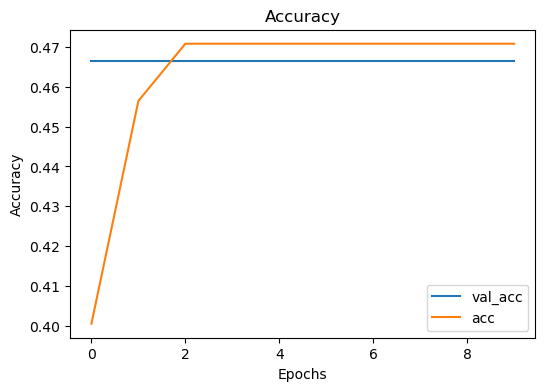

In [74]:
visualize_training_results(dropout_model_val)

This model also performs poorer than the baseline models.


## Convoluted Neural Network (CNN) model

CNN models are known to perform well on image recognition tasks.

# Resume here**************************

In [41]:
cnn_train, cnn_test, cnn_train_labels, cnn_test_labels= train_test_split(train_images, y_train, test_size=0.2, random_state=42,shuffle=True)


In [42]:
np.random.seed(42)
cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(64, 64, 3))) 
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(64, activation='relu'))
cnn_model.add(layers.Dense(5, activation='sigmoid'))

cnn_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['acc'])
cnn_results = cnn_model.fit(cnn_train,
                            cnn_train_labels, 
                            epochs=10,
                            batch_size=16,
                            validation_data=(cnn_test, cnn_test_labels))

Epoch 1/10
283/283 [==============================] - 12s 37ms/step - loss: 0.4213 - acc: 0.4967 - val_loss: 0.4073 - val_acc: 0.5141
Epoch 2/10
283/283 [==============================] - 11s 37ms/step - loss: 0.3759 - acc: 0.5939 - val_loss: 0.3800 - val_acc: 0.5707
Epoch 3/10
283/283 [==============================] - 10s 35ms/step - loss: 0.3621 - acc: 0.6057 - val_loss: 0.3734 - val_acc: 0.5751
Epoch 4/10
283/283 [==============================] - 10s 36ms/step - loss: 0.3542 - acc: 0.6167 - val_loss: 0.3679 - val_acc: 0.5866
Epoch 5/10
283/283 [==============================] - 10s 37ms/step - loss: 0.3404 - acc: 0.6342 - val_loss: 0.3322 - val_acc: 0.6325
Epoch 6/10
283/283 [==============================] - 11s 37ms/step - loss: 0.3389 - acc: 0.6337 - val_loss: 0.3476 - val_acc: 0.6069
Epoch 7/10
283/283 [==============================] - 10s 36ms/step - loss: 0.3311 - acc: 0.6415 - val_loss: 0.3307 - val_acc: 0.6334
Epoch 8/10
283/283 [==============================] - 11s 38ms

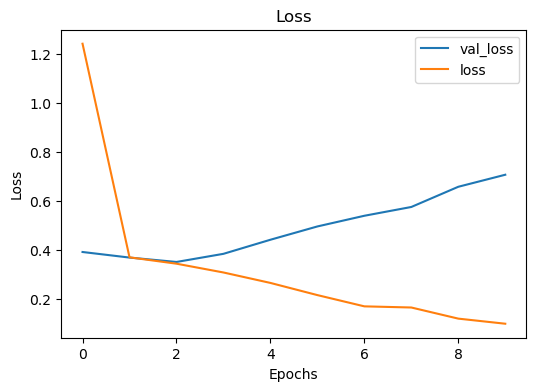

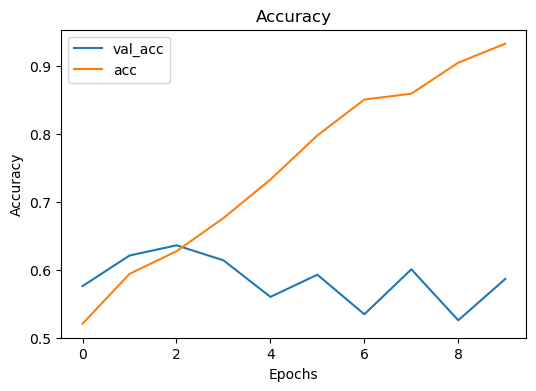

In [26]:
visualize_training_results(cnn_results)

In [27]:
cnn_model.predict(train_images)

177/177 [==============================] - 12s 68ms/step


array([[5.1249697e-07, 1.9317856e-03, 9.9340749e-01, 6.2344860e-02,
        1.7155960e-02],
       [1.0558135e-01, 3.5984794e-04, 4.0460226e-01, 2.3508331e-02,
        9.7997300e-03],
       [9.9233079e-01, 1.8491241e-01, 1.0978829e-05, 1.5902966e-01,
        2.3995996e-02],
       ...,
       [5.1793829e-02, 2.5768282e-03, 2.8023526e-01, 4.5248419e-01,
        5.4473942e-03],
       [1.2845878e-04, 1.8595099e-03, 1.6756457e-03, 9.7407860e-01,
        3.2226811e-04],
       [9.9889231e-01, 7.6673430e-05, 1.2269839e-08, 6.9118198e-03,
        5.8305331e-02]], dtype=float32)

In [28]:
cnn_model.evaluate(train_images)

177/177 [==============================] - 1s 3ms/step - loss: 0.0000e+00 - acc: 0.0000e+00


[0.0, 0.0]

The model performs very well on the training data, yet not nearly as well on the validation data. Nevertheless, it is still an imporvement from the previous models.

# Binary classification

While it is ideal to be able to identify specific diseases, detecting disease is an important first step. This next section seeks to classify images into one of two classes, healthy and diseased. 

# Modeling

In [36]:
binary_train, binary_test, binary_train_labels, binary_test_labels= train_test_split(train_img_unrow, new, test_size=0.2, random_state=42,shuffle=True)


### basic network binary

In [73]:
#instantiate model
#np.random.seed(42)
binary_model_1 = models.Sequential()
binary_model_1.add(layers.Dense(256, activation='tanh', input_shape=(49152,)))
binary_model_1.add(layers.Dense(2, activation='softmax'))

binary_model_1.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['AUC'])


In [74]:
binary_model_1.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_19 (Dense)            (None, 256)               12583168  
                                                                 
 dense_20 (Dense)            (None, 2)                 514       
                                                                 
Total params: 12583682 (48.00 MB)
Trainable params: 12583682 (48.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [75]:
binary_results_1 = binary_model_1.fit(binary_train, 
                        binary_train_labels,
                        epochs=10,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/10
283/283 [==============================] - 22s 71ms/step - loss: 0.2395 - auc: 0.9455 - val_loss: 0.2351 - val_auc: 0.9336
Epoch 2/10
283/283 [==============================] - 18s 64ms/step - loss: 0.2154 - auc: 0.9471 - val_loss: 0.2553 - val_auc: 0.9378
Epoch 3/10
283/283 [==============================] - 18s 63ms/step - loss: 0.2170 - auc: 0.9459 - val_loss: 0.2325 - val_auc: 0.9381
Epoch 4/10
283/283 [==============================] - 18s 63ms/step - loss: 0.2154 - auc: 0.9454 - val_loss: 0.2398 - val_auc: 0.9377
Epoch 5/10
283/283 [==============================] - 18s 64ms/step - loss: 0.2139 - auc: 0.9489 - val_loss: 0.2424 - val_auc: 0.9375
Epoch 6/10
283/283 [==============================] - 18s 63ms/step - loss: 0.2143 - auc: 0.9478 - val_loss: 0.2357 - val_auc: 0.9375
Epoch 7/10
283/283 [==============================] - 19s 66ms/step - loss: 0.2144 - auc: 0.9483 - val_loss: 0.2326 - val_auc: 0.9378
Epoch 8/10
283/283 [==============================] - 18s 65ms

With a training accuracy of 48.5% and testing accuracy of 47%, there is lots of room for improvement. 

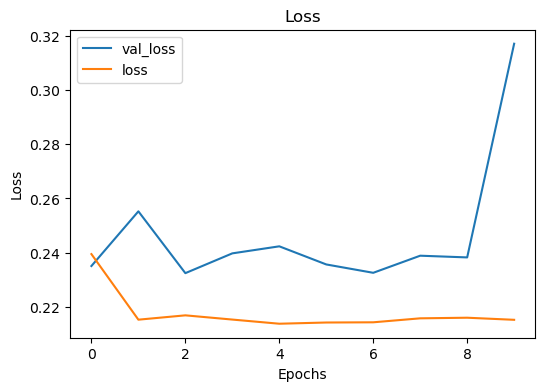

KeyError: 'val_acc'

<Figure size 600x400 with 0 Axes>

In [76]:
visualize_training_results(binary_results_1)

comments.....

## Network with 1 hidden layer- binary

In [55]:
#np.random.seed(42)
binary_model_2 = models.Sequential()
binary_model_2.add(layers.Dense(256, activation='relu', input_shape=(49152,))) 
binary_model_2.add(layers.Dense(32, activation='relu'))
binary_model_2.add(layers.Dense(2, activation='sigmoid'))
binary_model_2.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['AUC'])

binary_results_2 = binary_model_2.fit(binary_train, 
                        binary_train_labels,
                        epochs=10,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/10


TypeError: in user code:

    File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1401, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1384, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1373, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1155, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\engine\training.py", line 1249, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\engine\compile_utils.py", line 620, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\utils\metrics_utils.py", line 77, in decorated
        result = update_state_fn(*args, **kwargs)
    File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\metrics\base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "C:\Users\lalyn\anaconda3\lib\site-packages\keras\src\metrics\base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: 'str' object is not callable


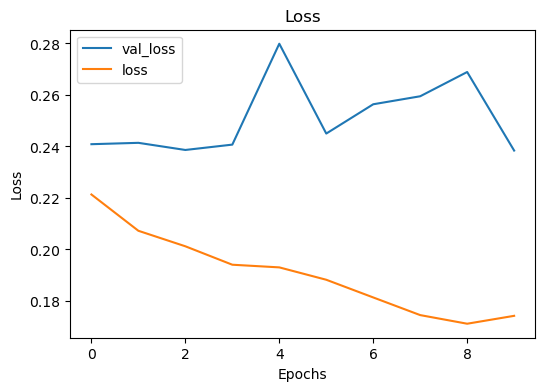

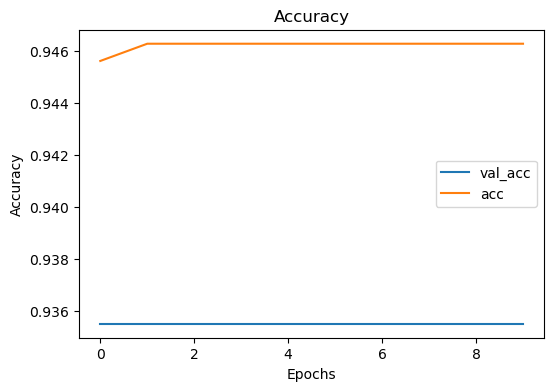

In [44]:
visualize_training_results(binary_results_2)

comments - after 10 eopochs.....

## Network model with 2 hidden layers - binary

In [182]:
np.random.seed(42)
binary_model_3 = models.Sequential()
binary_model_3.add(layers.Dense(256, activation='relu', input_shape=(49152,))) 
binary_model_3.add(layers.Dense(64, activation='relu'))
binary_model_3.add(layers.Dense(16, activation='relu'))
binary_model_3.add(layers.Dense(2, activation='sigmoid'))
binary_model_3.compile(optimizer='sgd',
              loss='binary_crossentropy',
              metrics=['acc'])

binary_results_3 = binary_model_3.fit(binary_train, 
                        binary_train_labels,
                        epochs=10,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/10
377/377 [==============================] - 9s 21ms/step - loss: 0.2356 - acc: 0.9432 - val_loss: 0.2140 - val_acc: 0.9461
Epoch 2/10
377/377 [==============================] - 8s 21ms/step - loss: 0.2232 - acc: 0.9436 - val_loss: 0.2171 - val_acc: 0.9461
Epoch 3/10
377/377 [==============================] - 8s 21ms/step - loss: 0.2221 - acc: 0.9436 - val_loss: 0.2142 - val_acc: 0.9461
Epoch 4/10
377/377 [==============================] - 8s 20ms/step - loss: 0.2200 - acc: 0.9436 - val_loss: 0.2144 - val_acc: 0.9461
Epoch 5/10
377/377 [==============================] - 7s 20ms/step - loss: 0.2175 - acc: 0.9436 - val_loss: 0.2139 - val_acc: 0.9461
Epoch 6/10
377/377 [==============================] - 7s 20ms/step - loss: 0.2173 - acc: 0.9436 - val_loss: 0.2134 - val_acc: 0.9461
Epoch 7/10
377/377 [==============================] - 8s 20ms/step - loss: 0.2135 - acc: 0.9436 - val_loss: 0.2168 - val_acc: 0.9461
Epoch 8/10
377/377 [==============================] - 7s 19ms/step - 

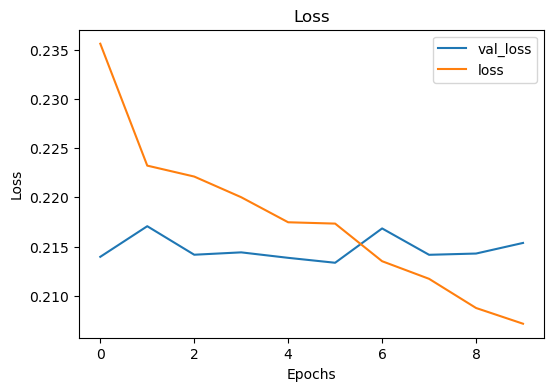

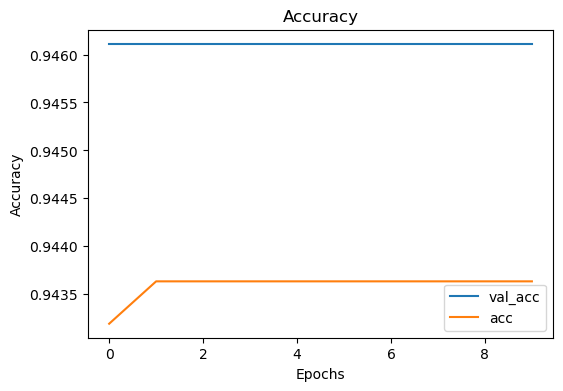

In [183]:
visualize_training_results(binary_results_3)

comments - after 10 eopochs.....

### grid search to find best params in binary model

In [226]:
def buildModel_binary(optimizer):
    # Initialising the ANN
    classifier = models.Sequential()
    
    # Adding the input layer and the first hidden layer
    classifier.add(layers.Dense(128, activation = 'relu', input_shape=(49152,)))
    
    # Adding the second hidden layer
    classifier.add(layers.Dense(32, activation='relu'))
        
    # Adding the output layer
    classifier.add(layers.Dense(2, activation='sigmoid'))
    
    # Compiling the ANN
    classifier.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['acc'])
    
    return classifier



In [231]:
binary_classifier = KerasRegressor(build_fn = buildModel_binary)
#What hyperparameter we want to play with
parameters = {'batch_size': [16, 32, 64, 128],
              'epochs': [5, 10, 50, 100],
              'optimizer': ['adam', 'sgd' 'rmsprop']}
binary_grid_search = GridSearchCV(estimator = binary_classifier,
                           param_grid = parameters,
                           scoring = 'neg_mean_absolute_error',
                           cv = 5)
binary_grid_search = binary_grid_search.fit(binary_train, binary_train_labels, verbose = 0)

C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-pa

C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-pa

C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-pa

C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-pa

C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-packages\scikeras\wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
C:\Users\lalyn\anaconda3\lib\site-pa

TypeError: buildModel_binary() missing 1 required positional argument: 'optimizer'

In [232]:
binary_best_parameters = binary_grid_search.best_params_
best_score = binary_grid_search.best_score_

print("Best Parameters: " + str(best_parameters))

Best Parameters: {'batch_size': 16, 'epochs': 5, 'optimizer': 'adam'}


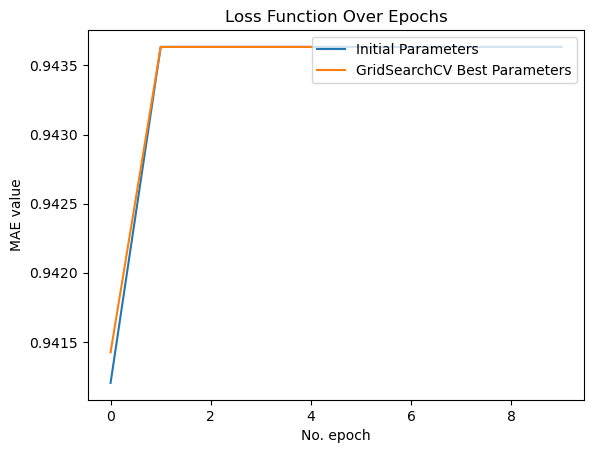

In [234]:
best_binary_Classifier = buildModel_binary('adam')
HistoryBest_binary = best_binary_Classifier.fit(binary_train, binary_train_labels, batch_size = 16, epochs =5 , verbose = 0)
plt.plot(binary_results_2.history['acc'], label='Initial Parameters')
plt.plot(HistoryBest_binary.history['acc'], label='GridSearchCV Best Parameters')
plt.title('Loss Function Over Epochs')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

## L2 reg.

In [194]:
# Import regularizers
from keras import regularizers

np.random.seed(42)

binary_L2_model = models.Sequential()

# Add the input and first hidden layer
binary_L2_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.005), input_shape=(49152,)))

# Add another hidden layer
binary_L2_model.add(layers.Dense(32, kernel_regularizer=regularizers.l2(0.005), activation='relu'))

# Add an output layer
binary_L2_model.add(layers.Dense(2, activation='softmax'))

# Compile the model
binary_L2_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
binary_L2_model_results = binary_L2_model.fit(binary_train, 
                        binary_train_labels,
                        epochs=5,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/5
283/283 [==============================] - 14s 39ms/step - loss: 1.1987 - acc: 0.9330 - val_loss: 0.4929 - val_acc: 0.9461
Epoch 2/5
283/283 [==============================] - 10s 34ms/step - loss: 0.4065 - acc: 0.9436 - val_loss: 0.3389 - val_acc: 0.9461
Epoch 3/5
283/283 [==============================] - 10s 35ms/step - loss: 0.3154 - acc: 0.9436 - val_loss: 0.2791 - val_acc: 0.9461
Epoch 4/5
283/283 [==============================] - 10s 35ms/step - loss: 0.2873 - acc: 0.9436 - val_loss: 0.2638 - val_acc: 0.9461
Epoch 5/5
283/283 [==============================] - 11s 38ms/step - loss: 0.2772 - acc: 0.9436 - val_loss: 0.2672 - val_acc: 0.9461


In [75]:
visualize_training_results(binary_L2_model_results)

NameError: name 'binary_L2_model_results' is not defined

## L1 reg

In [195]:
np.random.seed(42)

binary_L1_model = models.Sequential()

# Add the input and first hidden layer
binary_L1_model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l1(0.005), input_shape=(49152,)))

# Add a hidden layer
binary_L1_model.add(layers.Dense(32, kernel_regularizer=regularizers.l1(0.005), activation='relu'))

# Add an output layer
binary_L1_model.add(layers.Dense(2, activation='softmax'))

# Compile the model
binary_L1_model.compile(optimizer='adam', 
                 loss='categorical_crossentropy', 
                 metrics=['acc'])

# Train the model 
binary_L1_model_val = binary_L1_model.fit(binary_train, 
                        binary_train_labels,
                        epochs=5,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/5
283/283 [==============================] - 15s 42ms/step - loss: 7.6588 - acc: 0.9401 - val_loss: 1.6176 - val_acc: 0.9461
Epoch 2/5
283/283 [==============================] - 11s 39ms/step - loss: 1.5232 - acc: 0.9436 - val_loss: 1.4310 - val_acc: 0.9461
Epoch 3/5
283/283 [==============================] - 11s 38ms/step - loss: 1.3023 - acc: 0.9436 - val_loss: 1.3208 - val_acc: 0.9461
Epoch 4/5
283/283 [==============================] - 11s 39ms/step - loss: 1.1901 - acc: 0.9436 - val_loss: 1.1594 - val_acc: 0.9461
Epoch 5/5
283/283 [==============================] - 12s 43ms/step - loss: 1.1325 - acc: 0.9436 - val_loss: 1.1018 - val_acc: 0.9461


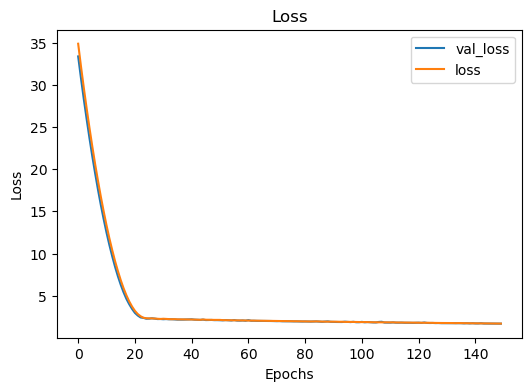

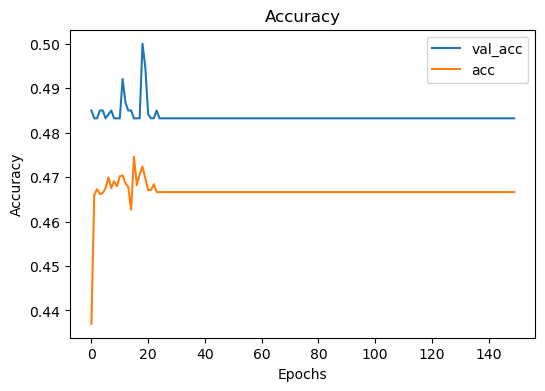

In [57]:
visualize_training_results(binary_L1_model_val)

## dropout reg

In [196]:
np.random.seed(42)
binary_dropout_model = models.Sequential()

# Implement dropout to the input layer
# NOTE: This is where you define the number of units in the input layer
binary_dropout_model.add(layers.Dropout(0.3, input_shape=(49152,)))

# Add the first hidden layer
binary_dropout_model.add(layers.Dense(128, activation='relu'))

# Implement dropout to the first hidden layer 
binary_dropout_model.add(layers.Dropout(0.3))

# Add the second hidden layer
binary_dropout_model.add(layers.Dense(32, activation='relu'))

# Implement dropout to the second hidden layer 
binary_dropout_model.add(layers.Dropout(0.3))

# Add the output layer
binary_dropout_model.add(layers.Dense(2, activation='softmax'))


# Compile the model
binary_dropout_model.compile(optimizer='adam', 
                      loss='categorical_crossentropy', 
                      metrics=['acc'])

# Train the model
binary_dropout_model_val = binary_dropout_model.fit(binary_train, 
                        binary_train_labels,
                        epochs=5,
                        batch_size=16,
                        validation_data=(binary_test, binary_test_labels))

Epoch 1/5
283/283 [==============================] - 14s 39ms/step - loss: 0.4477 - acc: 0.9184 - val_loss: 0.2335 - val_acc: 0.9461
Epoch 2/5
283/283 [==============================] - 11s 37ms/step - loss: 0.2667 - acc: 0.9410 - val_loss: 0.2233 - val_acc: 0.9461
Epoch 3/5
283/283 [==============================] - 10s 37ms/step - loss: 0.2519 - acc: 0.9436 - val_loss: 0.2250 - val_acc: 0.9461
Epoch 4/5
283/283 [==============================] - 11s 38ms/step - loss: 0.2536 - acc: 0.9436 - val_loss: 0.2107 - val_acc: 0.9461
Epoch 5/5
283/283 [==============================] - 11s 40ms/step - loss: 0.2308 - acc: 0.9436 - val_loss: 0.2131 - val_acc: 0.9461


In [39]:
visualize_training_results(binary_dropout_model_val)

NameError: name 'binary_dropout_model_val' is not defined


## CNN model

# Resume here**************************

In [77]:
cnn_binary_train, cnn_binary_test, cnn_binary_train_labels, cnn_binary_test_labels= train_test_split(train_images, new, test_size=0.2, random_state=42,shuffle=True)


In [78]:
np.random.seed(42)
binary_cnn_model = models.Sequential()
binary_cnn_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(128, 128, 3))) 
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Conv2D(32, (4, 4), activation='relu'))
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
binary_cnn_model.add(layers.MaxPooling2D((2, 2)))

binary_cnn_model.add(layers.Flatten())
binary_cnn_model.add(layers.Dense(64, activation='relu'))
binary_cnn_model.add(layers.Dense(2, activation='sigmoid'))

binary_cnn_model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['AUC'])
binary_cnn_results = binary_cnn_model.fit(cnn_binary_train,
                            cnn_binary_train_labels,
                            epochs=5,
                            batch_size=16,
                            validation_data=(cnn_binary_test, cnn_binary_test_labels))

Epoch 1/5
283/283 [==============================] - 50s 168ms/step - loss: 0.7568 - auc: 0.9464 - val_loss: 0.2335 - val_auc: 0.9598
Epoch 2/5
283/283 [==============================] - 44s 156ms/step - loss: 0.2152 - auc: 0.9600 - val_loss: 0.2317 - val_auc: 0.9627
Epoch 3/5
283/283 [==============================] - 42s 147ms/step - loss: 0.2057 - auc: 0.9648 - val_loss: 0.2337 - val_auc: 0.9645
Epoch 4/5
283/283 [==============================] - 42s 149ms/step - loss: 0.1943 - auc: 0.9696 - val_loss: 0.2327 - val_auc: 0.9626
Epoch 5/5
283/283 [==============================] - 48s 171ms/step - loss: 0.1820 - auc: 0.9746 - val_loss: 0.2289 - val_auc: 0.9591


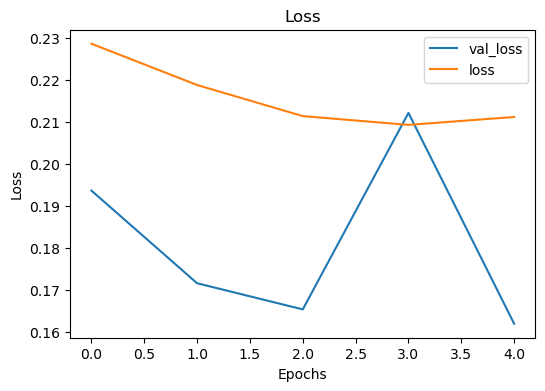

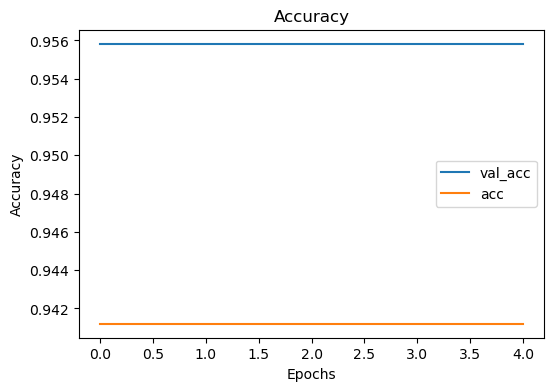

In [36]:
visualize_training_results(binary_cnn_results)

In [41]:
binary_cnn_model.predict(cnn_binary_train)

142/142 [==============================] - 4s 29ms/step


array([[0.04607533, 0.95416397],
       [0.05073219, 0.9479766 ],
       [0.05085381, 0.9469376 ],
       ...,
       [0.07346795, 0.92406535],
       [0.0275506 , 0.97158164],
       [0.0885951 , 0.9092826 ]], dtype=float32)

In [243]:
binary_cnn_model.evaluate(cnn_binary_train)

142/142 [==============================] - 1s 4ms/step - loss: 0.0000e+00 - acc: 0.0000e+00


[0.0, 0.0]

## Early stopping tuning-neural-networks-with-regularization-lab

In [ ]:
# Import EarlyStopping and ModelCheckpoint
from keras.callbacks import EarlyStopping, ModelCheckpoint

# Define the callbacks
early_stopping = [EarlyStopping(monitor='val_loss', patience=10), 
                  ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [ ]:
#train
model = model.fit(final_train, 
                          train_labels,
                          epochs=10, 
                          callbacks=early_stopping, 
                          batch_size=16, 
                          validation_data=(final_test, test_labels))
# eval
results = saved_model.evaluate(X_train_tokens, y_train_lb)


# LIME
https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb 

In [43]:
from keras.applications.imagenet_utils import decode_predictions
preds = cnn_model.predict(train_images)
print(preds[0:15])

177/177 [==============================] - 5s 28ms/step
[[5.9135440e-03 9.9439341e-01]
 [3.7662294e-02 9.5924532e-01]
 [8.3983272e-02 9.1501886e-01]
 [3.2005288e-02 9.6548671e-01]
 [4.2047478e-02 9.5785964e-01]
 [3.6402311e-02 9.6356839e-01]
 [2.3011500e-02 9.7665572e-01]
 [7.0993356e-02 9.2657787e-01]
 [5.9806723e-02 9.3758667e-01]
 [6.7659811e-04 9.9921525e-01]
 [1.5262397e-03 9.9838257e-01]
 [6.5549050e-04 9.9933511e-01]
 [1.9588258e-02 9.7950810e-01]
 [8.7181352e-02 9.1120934e-01]
 [7.0215389e-02 9.2357749e-01]]


In [44]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [45]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(train_images[0].astype('double'), cnn_model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 62ms/step
Wall time: 21.8 s


In [46]:
from skimage.segmentation import mark_boundaries

#### see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

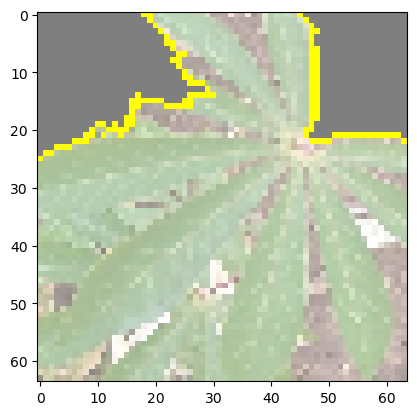

In [40]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#### Or with the rest of the image present:

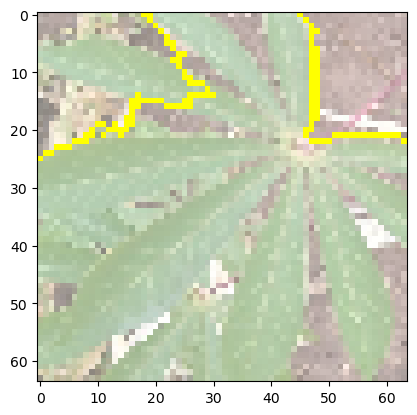

In [41]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#### see the 'pros and cons' (pros in green, cons in red)

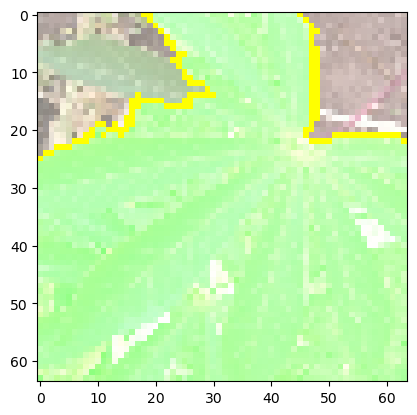

In [42]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#### plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.

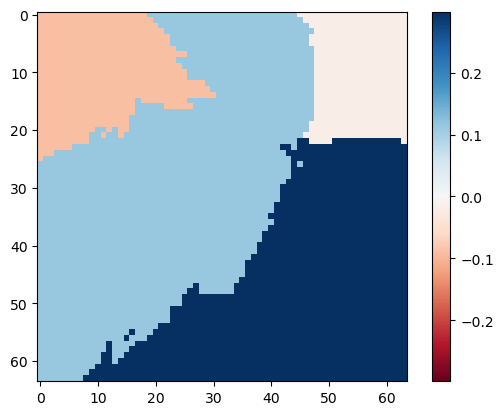

In [43]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

## Tuning models- pipeline stuff- keras wrapper?

In [7]:
def create_baseline_model():
    
    # Initialize model
    model = models.Sequential()

    # First hidden layer
    model.add(layers.Dense(10, activation='relu', input_shape=(n_features,)))

    # Second hidden layer
    model.add(layers.Dense(5, activation='relu'))

    # Output layer
    model.add(layers.Dense(1, activation='linear'))

    # Compile the model
    model.compile(optimizer='SGD', 
                  loss='mse',  
                  metrics=['mse']) 
    
    # Return the compiled model
    return model

In [8]:
keras_wrapper_1 = KerasRegressor(create_baseline_model,  
                                 epochs=150, 
                                 batch_size=256, 
                                 verbose=0)

C:\Users\lalyn\AppData\Local\Temp\ipykernel_15024\293714094.py:1: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  keras_wrapper_1 = KerasRegressor(create_baseline_model,


# Visualization

### intermediate activation functions

### display img

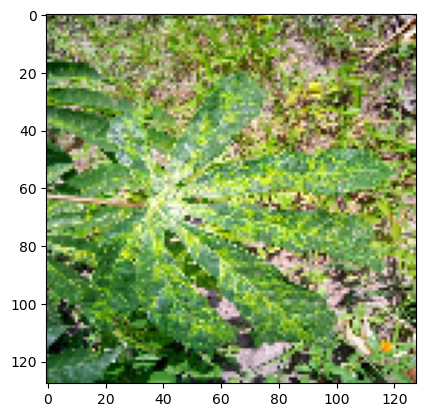

In [37]:
plt.imshow(train_images[0])
plt.show()




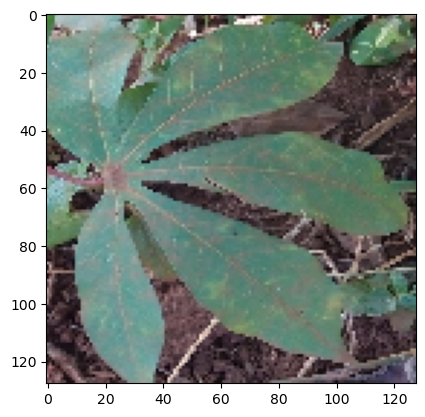

In [38]:

plt.imshow(test_images[0])
plt.show()


## visualize layers

In [43]:
layer_outputs = [layer.output for layer in cnn_model.layers[:8]]

# Rather then a model with a single output, we are going to make a model to display the feature maps
activation_model = models.Model(inputs=cnn_model.input, outputs=layer_outputs)

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 31, 31, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        16416     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 14, 14, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)         

### View third channel of first activation layer

In [44]:
# Returns an array for each activation layer
activations = activation_model.predict(train_images)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

# We slice the third channel and preview the results
plt.matshow(first_layer_activation[0, :, :, 3], cmap='viridis')
plt.show()

MemoryError: Unable to allocate 265. MiB for an array with shape (5656, 64, 64, 3) and data type float32

## channel 30 of first activation layer

In [60]:
# Repeating the process for another channel (the 30th)
activations = activation_model.predict(train_images)

first_layer_activation = activations[0]
print(first_layer_activation.shape)

plt.matshow(first_layer_activation[0, :, :, 5], cmap='viridis')
plt.show()

177/177 [==============================] - 28s 157ms/step


MemoryError: Unable to allocate 2.59 GiB for an array with shape (5656, 62, 62, 32) and data type float32

## view channel i of first activation layer

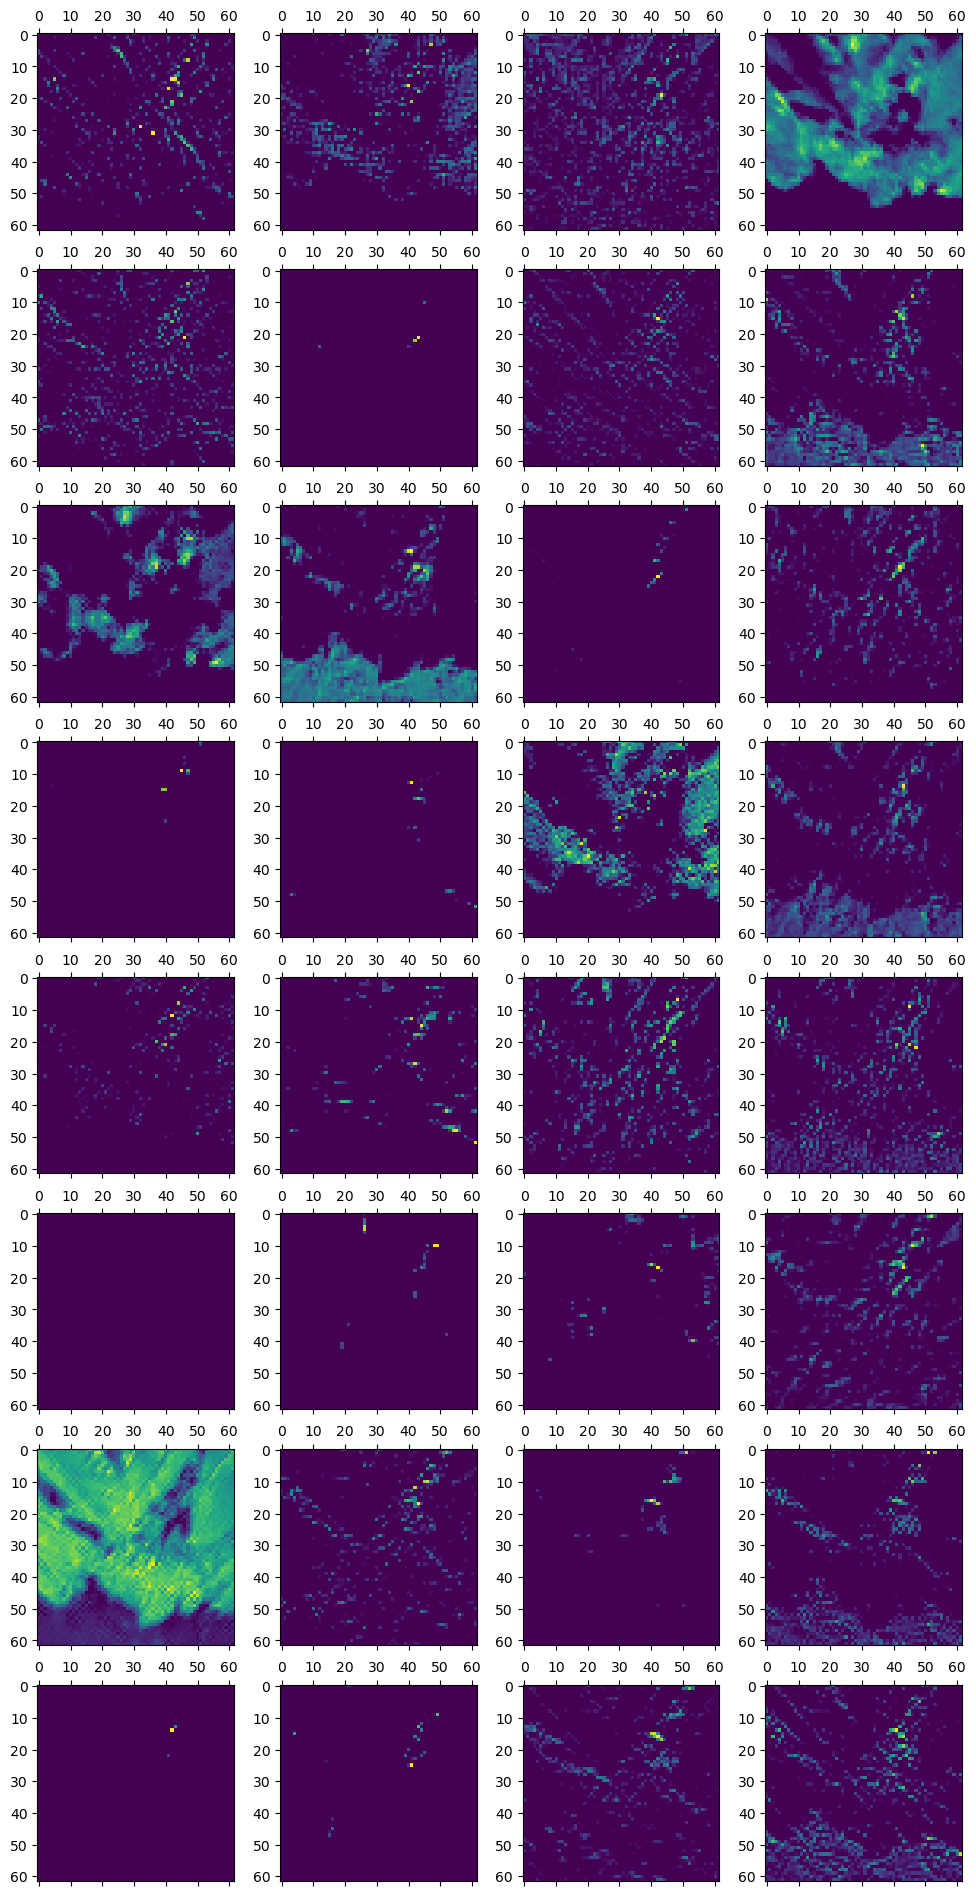

In [61]:
fig, axes = plt.subplots(8, 4, figsize=(12,24))
for i in range(32):
    row = i//4
    column = i%4
    ax = axes[row, column]
    first_layer_activation = activations[0]
    ax.matshow(first_layer_activation[0, :, :, i], cmap='viridis')

### View channel 29 for all activation layers

NameError: name 'activations' is not defined

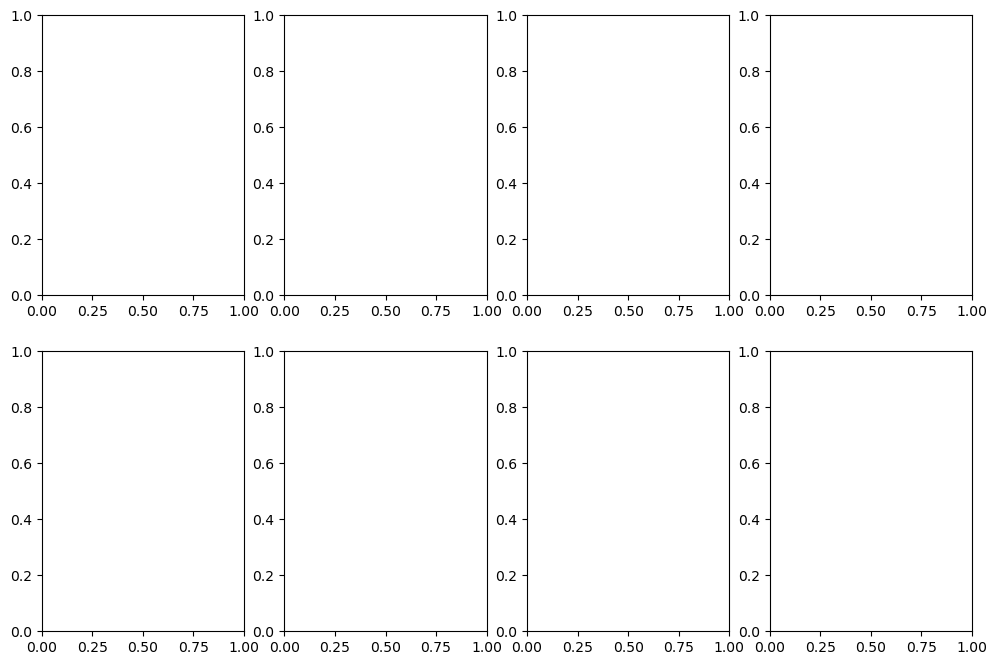

In [79]:
fig, axes = plt.subplots(2,4, figsize=(12,8))

layer_names = []
for layer in cnn_model.layers[:6]:
    layer_names.append(layer.name)

for i in range(8):
    row = i//4
    column = i%4
    ax = axes[row, column]
    cur_layer = activations[i]
    ax.matshow(cur_layer[0, :, :, 29], cmap='viridis')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_title(layer_names[i])

### visualize activation layers  lab - plot feature maps for each channel of all the layers

In [67]:
# Extract model layer outputs
layer_outputs = [layer.output for layer in cnn_model.layers[:8]]

# Create a model for displaying the feature maps
activation_model = models.Model(inputs=cnn_model.input, outputs=layer_outputs)

activations = activation_model.predict(train_images)

# Extract Layer Names for Labelling
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

total_features = sum([a.shape[-1] for a in activations])
total_features

n_cols = 16
n_rows = math.ceil(total_features / n_cols)


iteration = 0
fig , axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols, n_rows*1.5))

for layer_n, layer_activation in enumerate(activations):
    n_channels = layer_activation.shape[-1]
    for ch_idx in range(n_channels):
        row = iteration // n_cols
        column = iteration % n_cols
    
        ax = axes[row, column]

        channel_image = layer_activation[0,
                                         :, :,
                                         ch_idx]
        # Post-process the feature to make it visually palatable
        channel_image -= channel_image.mean()
        channel_image /= channel_image.std() 
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')

        ax.imshow(channel_image, aspect='auto', cmap='viridis')
        ax.get_xaxis().set_ticks([])
        ax.get_yaxis().set_ticks([])
        
        if ch_idx == 0:
            ax.set_title(layer_names[layer_n], fontsize=10)
        iteration += 1

fig.subplots_adjust(hspace=1.25)
plt.savefig('Intermediate_Activations_Visualized.pdf')
plt.show()

177/177 [==============================] - 63s 354ms/step


MemoryError: Unable to allocate 2.59 GiB for an array with shape (5656, 62, 62, 32) and data type float32

# LIME for binary 
https://github.com/marcotcr/lime/blob/master/doc/notebooks/Tutorial%20-%20Image%20Classification%20Keras.ipynb 

In [40]:
from keras.applications.imagenet_utils import decode_predictions
preds1 = binary_cnn_model.predict(train_images)
print(preds1[0:15])

177/177 [==============================] - 12s 65ms/step
[[2.3039395e-02 9.8029321e-01]
 [1.3486014e-04 9.9944919e-01]
 [2.2089439e-02 9.7952062e-01]
 [3.1032888e-02 9.7271079e-01]
 [2.9419765e-02 9.7437745e-01]
 [3.1873062e-02 9.7209477e-01]
 [7.4435450e-02 9.2986953e-01]
 [1.1116103e-02 9.8824924e-01]
 [5.1675271e-02 9.5386535e-01]
 [1.3023516e-15 1.0000000e+00]
 [1.1662795e-02 9.9032855e-01]
 [1.9195054e-02 9.8422837e-01]
 [7.7887792e-03 9.9161911e-01]
 [4.9422119e-02 9.5545626e-01]
 [8.9678355e-02 9.1502583e-01]]


In [41]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [42]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(train_images[10].astype('double'), binary_cnn_model.predict, top_labels=5, hide_color=0, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 [==============================] - 0s 54ms/step
Wall time: 15.2 s


In [43]:
from skimage.segmentation import mark_boundaries

#### see the top 5 superpixels that are most positive towards the class with the rest of the image hidden

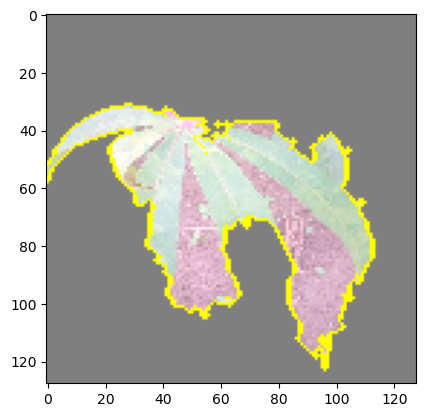

In [44]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#### Or with the rest of the image present:

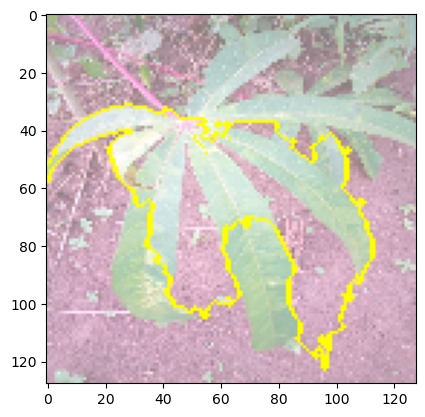

In [45]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#### see the 'pros and cons' (pros in green, cons in red)

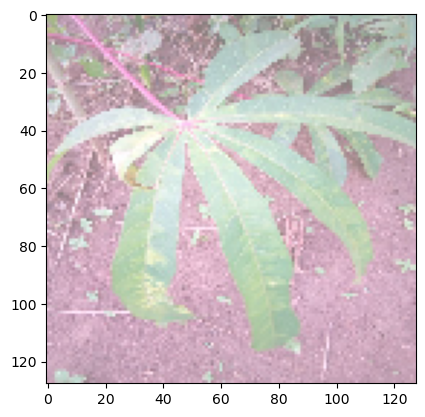

In [46]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

#### plot explanation weights onto a heatmap visualization. The colorbar shows the values of the weights.

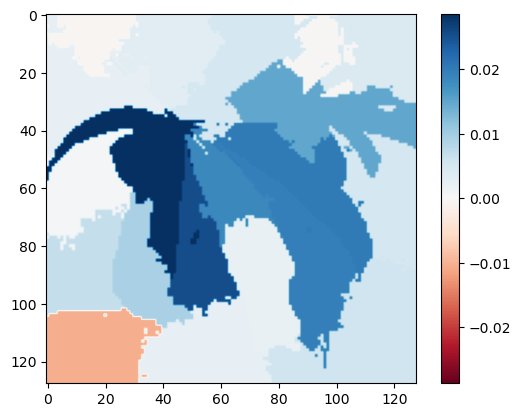

In [47]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()